In [135]:
import numpy as np
import qutip as qt
import math
import matplotlib.pyplot as plt
import q_solve
#from q_solve import generate_result

#Interesting things to look at: can you make the case where your worlds are orthogonal post measurements and project out an eigenstate of the composit hamiltonian happen?

In [136]:
#defining all quantities used in the simulation
d1, d2 = 10, 200
w = 0.3# smallest weight of the 2 eingestates, set btw 0 and 1
E_spacing = 1.0
Int_strength = 0.03
# Define the time settings for the simulation
tmax= 10
ind_nb = 100
#using all above to obtain QM qtts
result, tlist, H_q, H_system_2, H_system_1_ext, H_system_2_ext, H_interaction, H_total, ket_0, ket_1, initial_state_system_2 = generate_result(d1,d2,w, E_spacing, Int_strength, tmax, ind_nb)
time_indices = [0, 10, 20, 30, 49]  # Specify the time indices of interest

In [137]:
def compute_VN(result, time_index, subsystem_index=0):
    density_matrix = qt.ptrace(result.states[time_index], [subsystem_index])  # Calculate the density matrix at the specified time
    entropy = -np.sum(np.nan_to_num(np.log2(np.linalg.eigvals(density_matrix.full())) * np.linalg.eigvals(density_matrix.full())))
    return entropy

In [138]:
# Define a list to store the Von Neumann entropy at different times and fill it up.
von_neumann_entropy = []
for time_index in range(len(tlist)):
    entropy = compute_VN(result, time_index, subsystem_index=0)
    von_neumann_entropy.append(entropy)
    # ISSUE, does the entropy value make sense?

C:\Users\marin\AppData\Local\Temp\ipykernel_4236\3727334809.py:3: RuntimeWarning: divide by zero encountered in log2
  entropy = -np.sum(np.nan_to_num(np.log2(np.linalg.eigvals(density_matrix.full())) * np.linalg.eigvals(density_matrix.full())))
C:\Users\marin\AppData\Local\Temp\ipykernel_4236\3727334809.py:3: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(np.nan_to_num(np.log2(np.linalg.eigvals(density_matrix.full())) * np.linalg.eigvals(density_matrix.full())))


In [139]:
# Define function to compute schmidt states, the schmidt_values and return them in order
def compute_schmidt_states(result, time_index, subsystem_index=0, trigger=0):
    density_matrix = qt.ptrace(result.states[time_index], [subsystem_index]) # Calculate the density matrix at the specified time
    eigenvalues, eigenstates = density_matrix.eigenstates() # Compute the eigenstates and eigenvalues of the density matrix
    eigenstates = [np.array(state) for state in eigenstates]
    schmidt_states = []
    schmidt_values = []
    for state, eigenvalue in zip(eigenstates, eigenvalues):
        schmidt_values.append(eigenvalue)
        if eigenvalue == 0:
            # If the eigenvalue is zero, set the Schmidt state to a zero vector
            schmidt_states.append(np.zeros_like(state))
        else:
            schmidt_states.append(state / np.linalg.norm(state)) # Normalize
            #schmidt_states.append(state / np.sqrt(np.array(eigenvalue)))  # Normalize
    # Sort the Schmidt states by eigenvalue in descending order
    schmidt_states, schmidt_values = zip(*sorted(zip(schmidt_states, schmidt_values), key=lambda x: -x[1]))
    if trigger == 0:
        return schmidt_states
    else:
        return schmidt_values

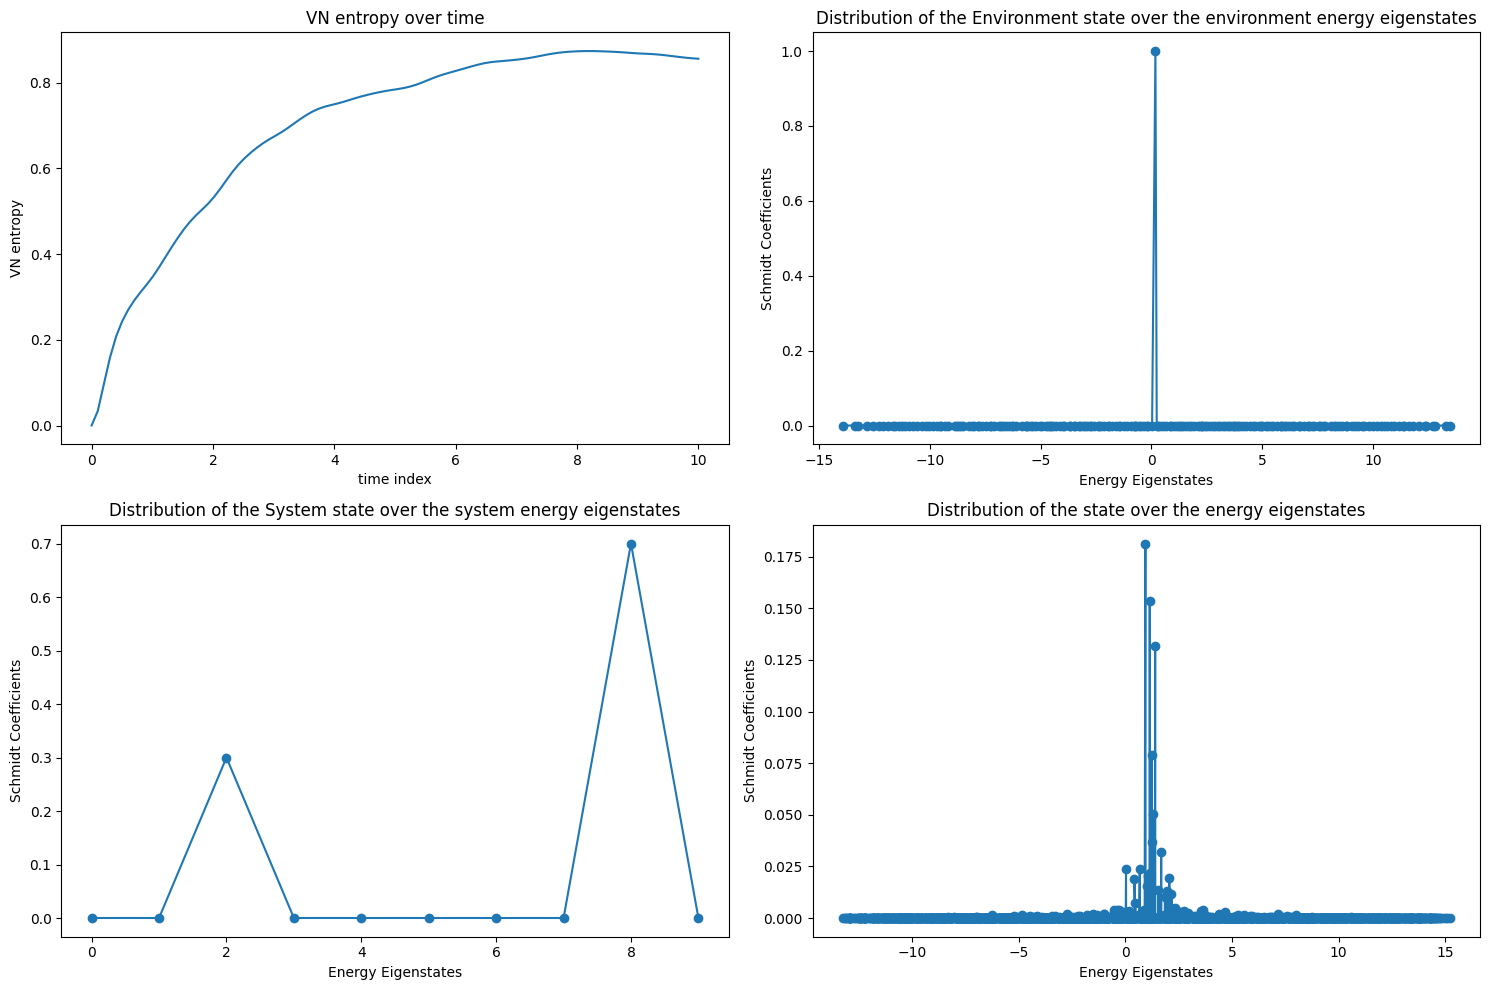

In [140]:
######This is a checkup to see if you program works

# Eigenstates and eigenenergies 
eigenenergies_system_2, eigenstates_system_2 = H_system_2.eigenstates() 
eigenenergies_system_total, eigenstates_system_total = H_total.eigenstates() 
eigenenergies_system_1, eigenstates_system_1 = H_q.eigenstates() 
# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: VN entropy over time
axes[0, 0].plot(tlist, von_neumann_entropy)
axes[0, 0].set_title("VN entropy over time")
axes[0, 0].set_xlabel("time index")
axes[0, 0].set_ylabel("VN entropy")

# Plot 2: Distribution of the Environment state over the environment energy eigenstates
time_index = 0  # Define the time index
s0 = compute_schmidt_states(result, time_index, 1)[0]
schmidt_coefficients0 = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates_system_2]
axes[0, 1].plot(eigenenergies_system_2, schmidt_coefficients0, marker='o', label=f'Energy {eigenenergies_system_2}')
axes[0, 1].set_title("Distribution of the Environment state over the environment energy eigenstates")
axes[0, 1].set_xlabel("Energy Eigenstates")
axes[0, 1].set_ylabel("Schmidt Coefficients")



# Plot 3: Distribution of the System state over the system energy eigenstates
s0 = compute_schmidt_states(result, time_index, 0)[0]
schmidt_coefficients0 = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates_system_1]
axes[1, 0].plot(eigenenergies_system_1, schmidt_coefficients0, marker='o', label=f'Energy {eigenenergies_system_1}')
axes[1, 0].set_title("Distribution of the System state over the system energy eigenstates")
axes[1, 0].set_xlabel("Energy Eigenstates")
axes[1, 0].set_ylabel("Schmidt Coefficients")

# Plot 4: Distribution of the state over the energy eigenstates
s0 = result.states[0]
schmidt_coefficients0 = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates_system_total]
axes[1, 1].plot(eigenenergies_system_total, schmidt_coefficients0, marker='o', label=f'Energy {eigenenergies_system_total}')
axes[1, 1].set_title("Distribution of the state over the energy eigenstates")
axes[1, 1].set_xlabel("Energy Eigenstates")
axes[1, 1].set_ylabel("Schmidt Coefficients")

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

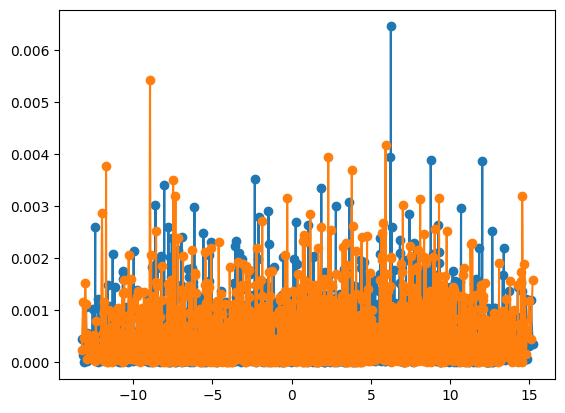

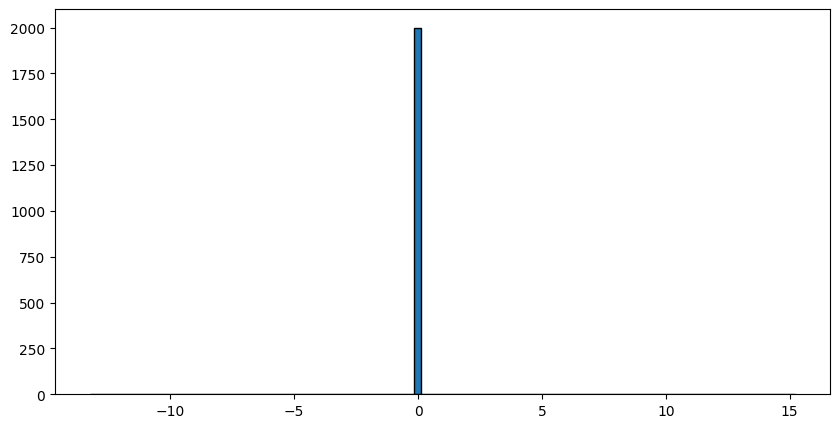

In [141]:
#take environment schimdt state
env_schmidt1 = compute_schmidt_states(result, 99, 1)[0]
#take system schmidt state
syst_schmidt1 = compute_schmidt_states(result, 99, 0)[0]
#####cant fo q-tensor since they are not q-objects. i need to do that by hand. just find the right way to make the product
#tensor product them
state1 = np.tensordot(env_schmidt1, syst_schmidt1,0)
#project them over the full energy spectrum
schmidt_coef1 = [abs(np.vdot(state1, eigenstate)) ** 2 for eigenstate in eigenstates_system_total]
#schmidt_coef1 = schmidt_coef1 / np.sqrt(np.sum(schmidt_coef1))
#plot that
plt.plot(eigenenergies_system_total, schmidt_coef1, marker='o', label=f'Energy {eigenenergies_system_total}')

#take environment schimdt state
env_schmidt2 = compute_schmidt_states(result, 99, 1)[1]
#take system schmidt state
syst_schmidt2 = compute_schmidt_states(result, 99, 0)[1]
#tensor product them
state2 = np.tensordot(env_schmidt2, syst_schmidt2,0)
#project them over the full energy spectrum
schmidt_coef2 = [abs(np.vdot(state2, eigenstate)) ** 2 for eigenstate in eigenstates_system_total]
#schmidt_coef2 = schmidt_coef2 / np.sqrt(np.sum(schmidt_coef2))
#plot that
plt.plot(eigenenergies_system_total, schmidt_coef2, marker='o', label=f'Energy {eigenenergies_system_total}')

plt.figure(figsize=(10, 5))
num_bins=100
min_energy=min(eigenenergies_system_total)
max_energy=max(eigenenergies_system_total)
plt.hist(schmidt_coef1, bins=num_bins, range=(min_energy, max_energy), edgecolor='black');


In [142]:
#computing a bunch of results
result0, tlist0, H_q0, H_system_2_0, H_system_1_ext_0, H_system_2_ext_0, H_interaction_0, H_total_0, ket_0_0, ket_1_0, initial_state_system_2_0 = generate_result(d1,d2,w, E_spacing, 0.001, tmax, ind_nb)
result1, tlist1, H_q1, H_system_2_1, H_system_1_ext_1, H_system_2_ext_1, H_interaction_1, H_total_1, ket_0_1, ket_1_, initial_state_system_2_1 = generate_result(d1,d2,w, E_spacing, 0.1, tmax, ind_nb)
result2, tlist2, H_q2, H_system_2_2, H_system_1_ext_2, H_system_2_ext_2, H_interaction_2, H_total_2, ket_0_2, ket_1_2, initial_state_system_2_2 = generate_result(d1,d2,w, E_spacing, 0.3, tmax, ind_nb)
result3, tlist3, H_q3, H_system_2_3, H_system_1_ext_3, H_system_2_ext_3, H_interaction_3, H_total_3, ket_0_3, ket_1_3, initial_state_system_2_3 = generate_result(d1,d2,w, E_spacing, 0.5, tmax, ind_nb)
result4, tlist4, H_q4, H_system_2_4, H_system_1_ext_4, H_system_2_ext_4, H_interaction_4, H_total_4, ket_0_4, ket_1_4, initial_state_system_2_4 = generate_result(d1,d2,w, E_spacing, 1, tmax, ind_nb)
# Eigenstates and eigenenergies
eigenenergies_system_total_0, eigenstates_system_total_0 = H_total_0.eigenstates() 
eigenenergies_system_total, eigenstates_system_total = H_total.eigenstates() 
eigenenergies_system_total_1, eigenstates_system_total_1 = H_total_1.eigenstates() 
eigenenergies_system_total_2, eigenstates_system_total_2 = H_total_2.eigenstates() 
eigenenergies_system_total_3, eigenstates_system_total_3 = H_total_3.eigenstates()
eigenenergies_system_total_4, eigenstates_system_total_4 = H_total_4.eigenstates()

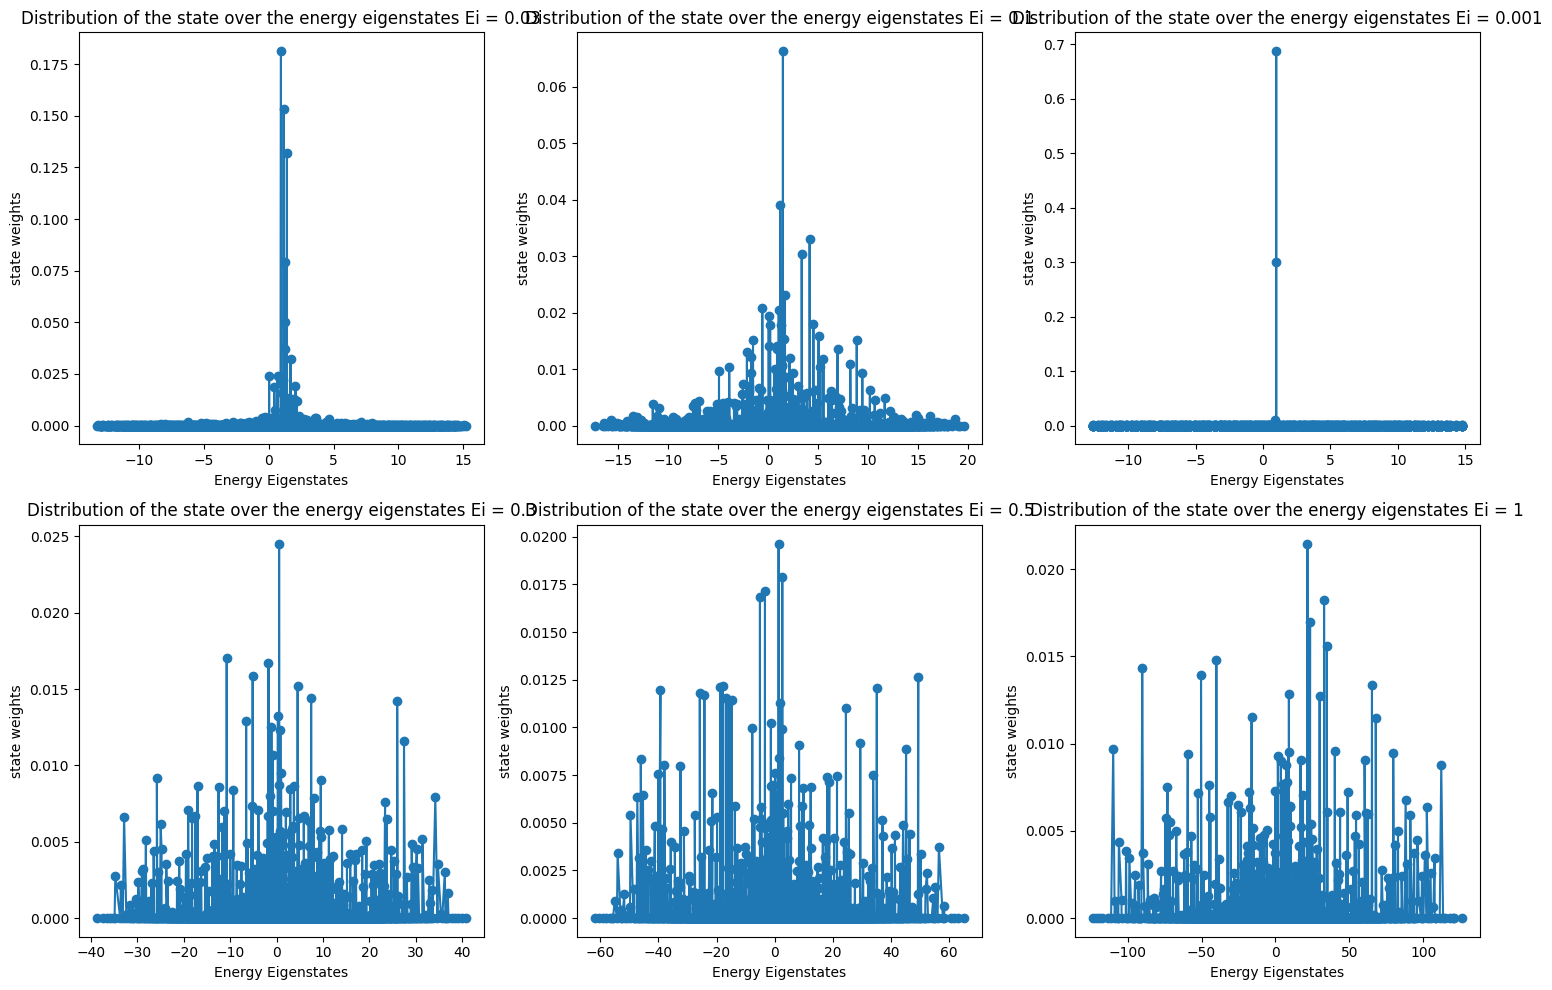

In [143]:
# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#NOTHING HERE IS A SCHMIDT COEFFICIENT, WHY DID I CALL THEM THAT

s0 = result0.states[0]
schmidt_coefficients0 = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates_system_total_0]
axes[0, 2].plot(eigenenergies_system_total_0, schmidt_coefficients0, marker='o', label=f'Energy {eigenenergies_system_total_0}')
axes[0, 2].set_title("Distribution of the state over the energy eigenstates Ei = 0.001")
axes[0, 2].set_xlabel("Energy Eigenstates")
axes[0, 2].set_ylabel("state weights")

# Plot 1:
s0 = result.states[0]
schmidt_coefficients0 = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates_system_total]
axes[0, 0].plot(eigenenergies_system_total, schmidt_coefficients0, marker='o', label=f'Energy {eigenenergies_system_total}')
axes[0, 0].set_title("Distribution of the state over the energy eigenstates Ei = 0.03")
axes[0, 0].set_xlabel("Energy Eigenstates")
axes[0, 0].set_ylabel("state weights")

# Plot 2:
s0 = result1.states[0]
schmidt_coefficients0 = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates_system_total_1]
axes[0, 1].plot(eigenenergies_system_total_1, schmidt_coefficients0, marker='o', label=f'Energy {eigenenergies_system_total_1}')
axes[0, 1].set_title("Distribution of the state over the energy eigenstates Ei = 0.1")
axes[0, 1].set_xlabel("Energy Eigenstates")
axes[0, 1].set_ylabel("state weights")

# Plot 3:
s0 = result2.states[0]
schmidt_coefficients0 = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates_system_total_2]
axes[1, 0].plot(eigenenergies_system_total_2, schmidt_coefficients0, marker='o', label=f'Energy {eigenenergies_system_total_2}')
axes[1, 0].set_title("Distribution of the state over the energy eigenstates Ei = 0.3")
axes[1, 0].set_xlabel("Energy Eigenstates")
axes[1, 0].set_ylabel("state weights")

# Plot 4: Distribution of the state over the energy eigenstates
s0 = result3.states[0]
schmidt_coefficients0 = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates_system_total_3]
axes[1, 1].plot(eigenenergies_system_total_3, schmidt_coefficients0, marker='o', label=f'Energy {eigenenergies_system_total_3}')
axes[1, 1].set_title("Distribution of the state over the energy eigenstates Ei = 0.5")
axes[1, 1].set_xlabel("Energy Eigenstates")
axes[1, 1].set_ylabel("state weights")

s0 = result4.states[0]
schmidt_coefficients0 = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates_system_total_4]
axes[1, 2].plot(eigenenergies_system_total_4, schmidt_coefficients0, marker='o', label=f'Energy {eigenenergies_system_total_4}')
axes[1, 2].set_title("Distribution of the state over the energy eigenstates Ei = 1")
axes[1, 2].set_xlabel("Energy Eigenstates")
axes[1, 2].set_ylabel("state weights")

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

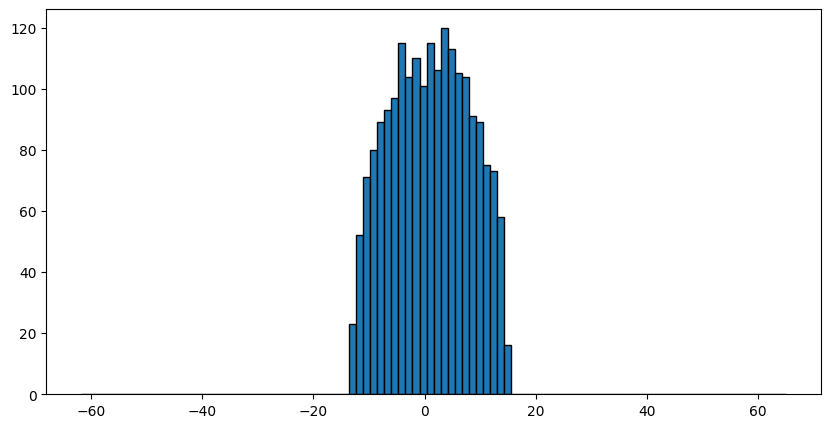

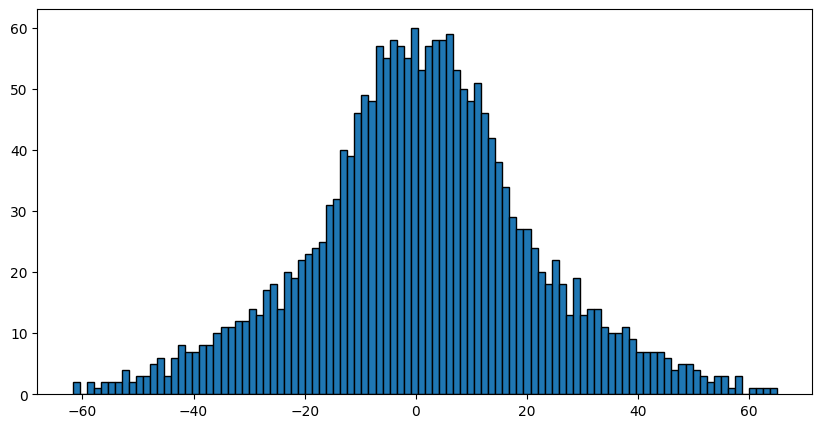

In [144]:
#other plots I want to see

#plot of the full energy spectrum, how is it distributed?
num_bins=100
min_energy=min(eigenenergies_system_total_3)
max_energy=max(eigenenergies_system_total_3)
plt.figure(figsize=(10, 5))
plt.hist(eigenenergies_system_total, bins=num_bins, range=(min_energy, max_energy), edgecolor='black');
#looks like a nice wigner semicircle, this is the thing, who's shape changes as the interaction energy increases. lets check that
plt.figure(figsize=(10, 5))
plt.hist(eigenenergies_system_total_3, bins=num_bins, range=(min_energy, max_energy), edgecolor='black');
#PERFECT wigner semi cirlce, vs weird cowboy hat


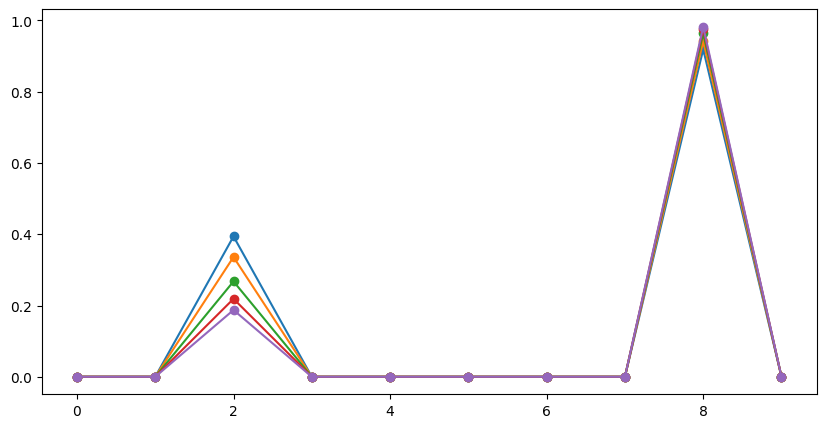

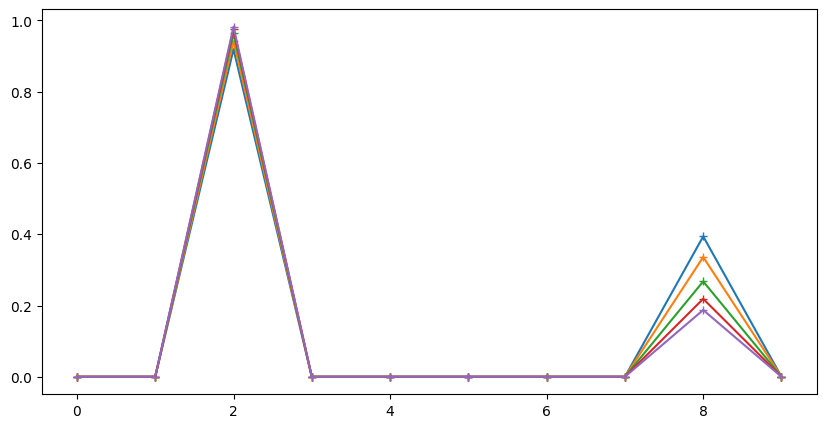

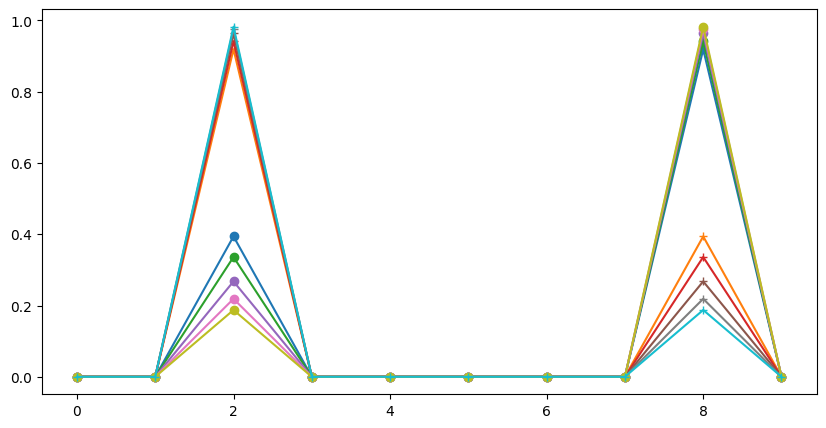

In [12]:
#plotting the main schmidt state projected over the energy eigenstates
plt.figure(figsize=(10, 5))
for idx in time_indices:
    s0=compute_schmidt_states(result, idx, 0)[0]
    schmidt_coefficients0 = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates_system_1]
    norm=np.linalg.norm(schmidt_coefficients0) #THIS IS A PATCHUP, I NEED TO FIGURE OUT WHAT IS WRONG WITH MY SCHMIDT STATES
    plt.plot(eigenenergies_system_1, schmidt_coefficients0/norm, marker='o', label=f'Energy {eigenenergies_system_1}')

#plotting the second schmidt state projected over the energy eigenstates
plt.figure(figsize=(10, 5))
for idx in time_indices:
    s1=compute_schmidt_states(result, idx, 0)[1]
    schmidt_coefficients1 = [abs(np.vdot(s1, eigenstate)) ** 2 for eigenstate in eigenstates_system_1]
    norm=np.linalg.norm(schmidt_coefficients1) #THIS IS A PATCHUP, I NEED TO FIGURE OUT WHAT IS WRONG WITH MY SCHMIDT STATES
    plt.plot(eigenenergies_system_1, schmidt_coefficients1/norm, marker='+', label=f'Energy {eigenenergies_system_1}')

#plotting the main schmidt state projected over the energy eigenstates
plt.figure(figsize=(10, 5))
for idx in time_indices:
    s0=compute_schmidt_states(result, idx, 0)[0]
    s1=compute_schmidt_states(result, idx, 0)[1]
    schmidt_coefficients0 = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates_system_1]
    schmidt_coefficients1 = [abs(np.vdot(s1, eigenstate)) ** 2 for eigenstate in eigenstates_system_1]
    norm0=np.linalg.norm(schmidt_coefficients0) #THIS IS A PATCHUP, I NEED TO FIGURE OUT WHAT IS WRONG WITH MY SCHMIDT STATES
    norm1=np.linalg.norm(schmidt_coefficients1) #THIS IS A PATCHUP, I NEED TO FIGURE OUT WHAT IS WRONG WITH MY SCHMIDT STATES
    plt.plot(eigenenergies_system_1, schmidt_coefficients0/norm0, marker='o', label=f'Energy {eigenenergies_system_1}')
    plt.plot(eigenenergies_system_1, schmidt_coefficients1/norm1, marker='+', label=f'Energy {eigenenergies_system_1}')

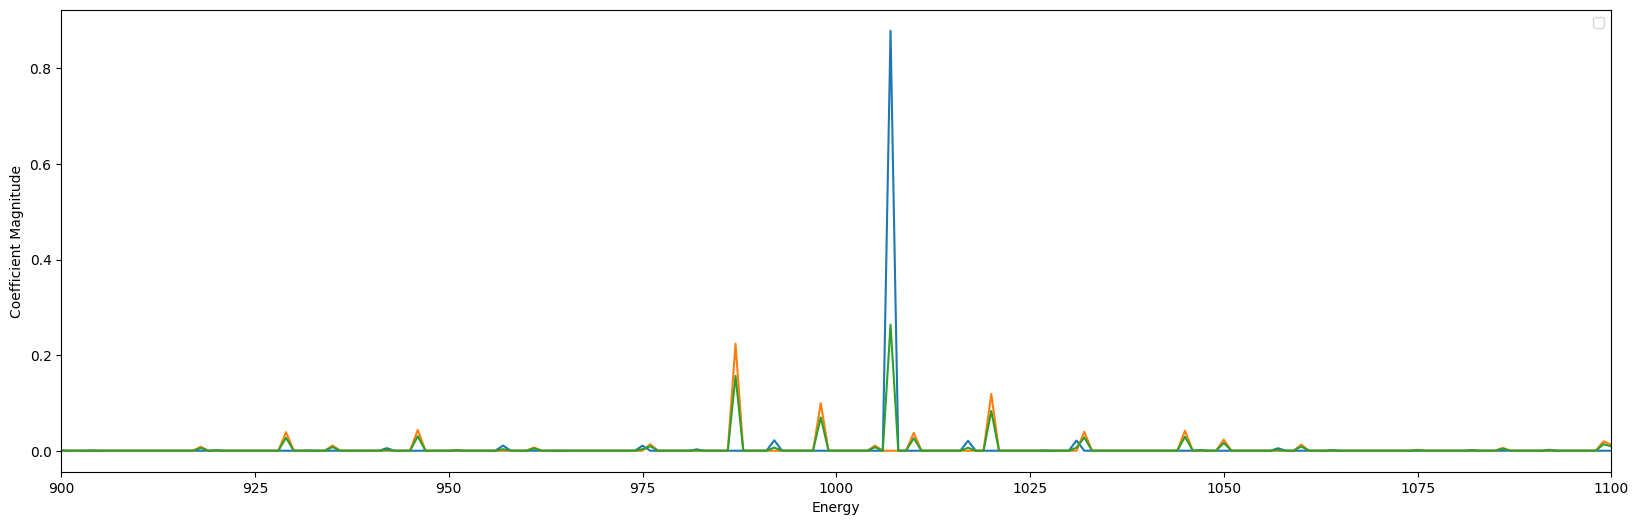

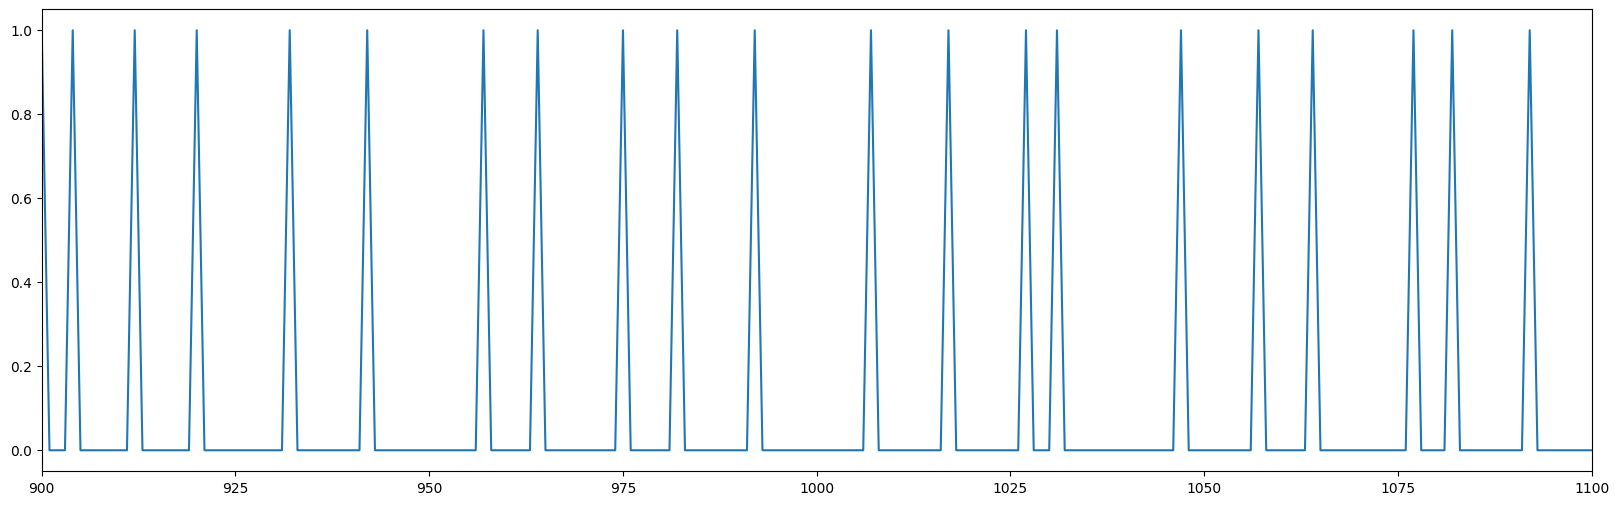

In [13]:
#Study of the distribution over the energy spectrum of ket(0)ket(E0) and ket(1)ket(E0)...

ket0E0 = qt.tensor(ket_0, initial_state_system_2).unit()
ket1E0 = qt.tensor(ket_1, initial_state_system_2).unit()
initial_state = qt.tensor((math.sqrt(0.3)*ket_0 + math.sqrt(1-0.3)*ket_1).unit(), initial_state_system_2).unit()
coefficients0 = [abs(np.vdot(ket0E0, eigenstate)) ** 2 for eigenstate in eigenstates_system_total]
coefficients1 = [abs(np.vdot(ket1E0, eigenstate)) ** 2 for eigenstate in eigenstates_system_total]
coefficients2 = [abs(np.vdot(initial_state, eigenstate)) ** 2 for eigenstate in eigenstates_system_total]
plt.figure(figsize=(20, 6))
plt.plot(coefficients0)
plt.plot(coefficients1)
plt.plot(coefficients2)
# Set the x-axis range
plt.xlim(900, 1100)
# Add labels, legend, and display the plot
plt.xlabel('Energy')
plt.ylabel('Coefficient Magnitude')
plt.legend()
plt.show()

# Create an array to count where coefficients0 and coefficients1 have nonzero overlap
nonzero_overlap_indices = []
nonzero_indices = []

for i in range(len(coefficients0)):
    if coefficients0[i] > 0:
        nonzero_indices.append(1)
    else:
        nonzero_indices.append(0)
nonzero_total=sum(nonzero_indices)

for i in range(len(coefficients0)):
    if coefficients0[i] > 0 and coefficients0[i] > 0:
        nonzero_overlap_indices.append(1)
    else:
        nonzero_overlap_indices.append(0)
total_overlap = sum(nonzero_overlap_indices)/(nonzero_total)

plt.figure(figsize=(20, 6))
plt.plot(nonzero_overlap_indices)
plt.xlim(900, 1100)

#Now we look at how this overlap number evolves when using 2 schmidt states

nonzero1=[]
nonzero_overlap=[]
t_ind = range(len(tlist))
t_ind_temp = [0,10,20]
total_overlap_time = []

for idx in t_ind:
    a = compute_schmidt_states(result, idx, 0, 0)[0]
    b = compute_schmidt_states(result, idx, 0, 0)[1]
    c = compute_schmidt_states(result, idx, 1, 0)[0]
    d = compute_schmidt_states(result, idx, 1, 0)[1]
    e = np.tensordot(a, c, 0)
    f = np.tensordot(b, d, 0)
    coef1 = [abs(np.vdot(e, eigenstate)) ** 2 for eigenstate in eigenstates_system_total]
    coef2 = [abs(np.vdot(f, eigenstate)) ** 2 for eigenstate in eigenstates_system_total]
    
    for i in range(len(coef1)):
        if coef1[i] > 0:
            nonzero1.append(1)
        else:
            nonzero1.append(0)
        nonzero_total=sum(nonzero_indices)
        
    for i in range(len(coef1)):
        if coef1[i] > 0 and coef2[i] > 0:
            nonzero_overlap.append(1)
        else:
            nonzero_overlap.append(0)
    total_overlap = sum(nonzero_overlap)/(nonzero_total)
    total_overlap_time.append(total_overlap)

In [14]:
print(total_overlap_time)

[2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 46.0, 48.0, 50.0, 52.0, 54.0, 56.0, 58.0, 60.0, 62.0, 64.0, 66.0, 68.0, 70.0, 72.0, 74.0, 76.0, 78.0, 80.0, 82.0, 84.0, 86.0, 88.0, 90.0, 92.0, 94.0, 96.0, 98.0, 100.0, 102.0, 104.0, 106.0, 108.0, 110.0, 112.0, 114.0, 116.0, 118.0, 120.0, 122.0, 124.0, 126.0, 128.0, 130.0, 132.0, 134.0, 136.0, 138.0, 140.0, 142.0, 144.0, 146.0, 148.0, 150.0, 152.0, 154.0, 156.0, 158.0, 160.0, 162.0, 164.0, 166.0, 168.0, 170.0, 172.0, 174.0, 176.0, 178.0, 180.0, 182.0, 184.0, 186.0, 188.0, 190.0, 192.0, 194.0, 196.0, 198.0, 200.0]


Text(0, 0.5, 'Eigenvalue Magnitude')

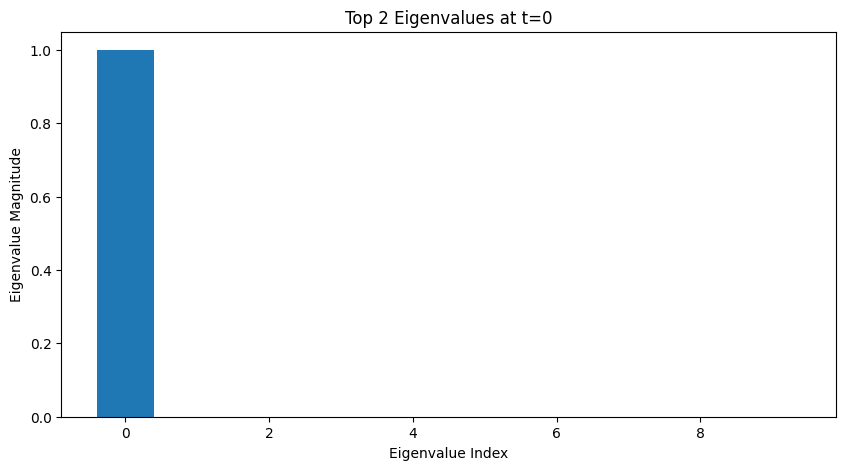

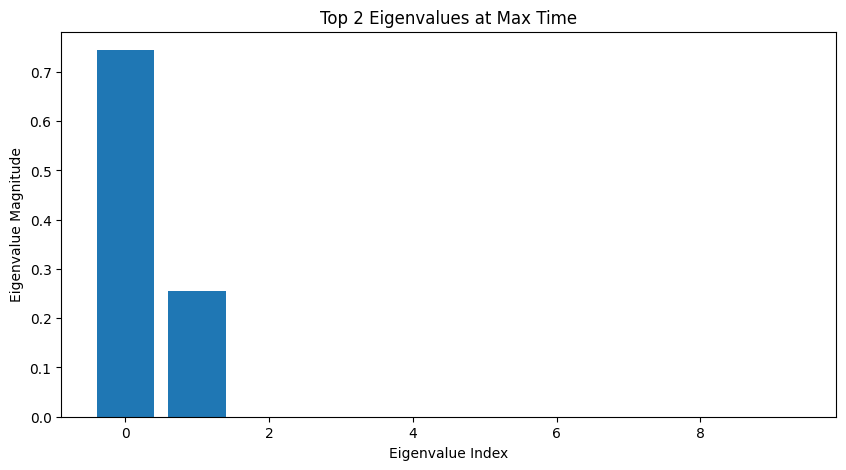

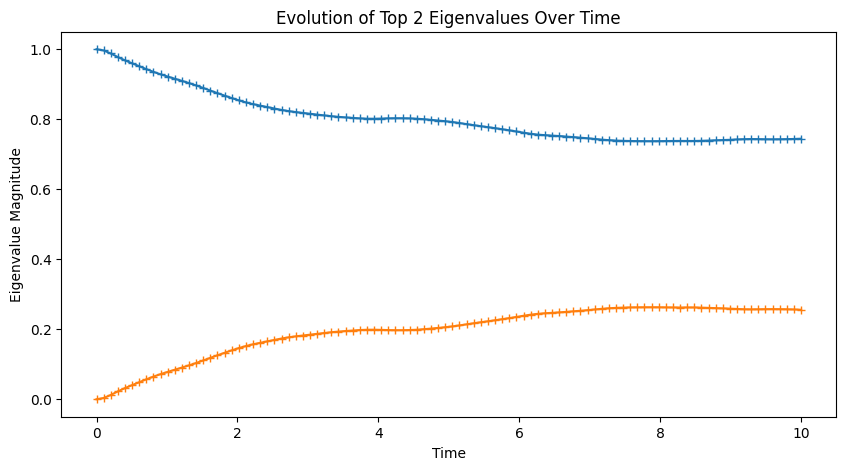

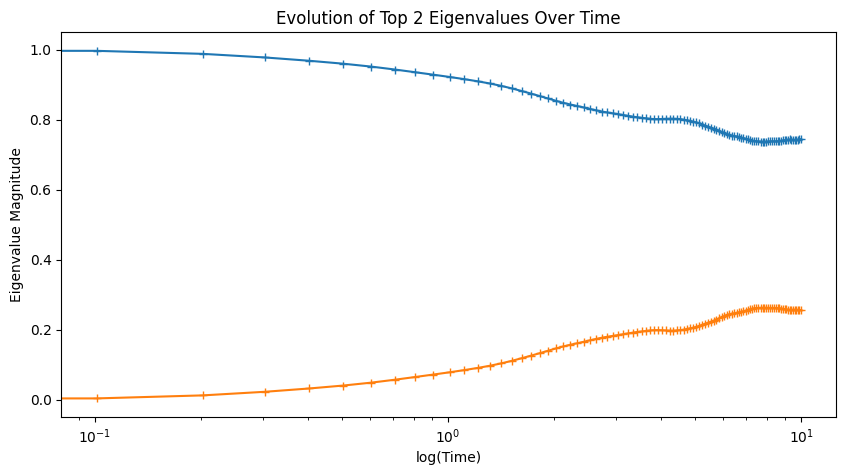

In [15]:
###plotting the top 2 eigenvalues of /rho
#I will probably need to get what is happening with my normalization to do that correctly, which is good

plt.figure(figsize=(10, 5))
s_val = compute_schmidt_states(result, 0, 0, 1)
plt.bar(range(len(s_val)), s_val)
plt.title('Top 2 Eigenvalues at t=0')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue Magnitude')

plt.figure(figsize=(10, 5))
s_val = compute_schmidt_states(result, -1, 0, 1) #-1 goes to the max time
plt.bar(range(len(s_val)), s_val)
plt.title('Top 2 Eigenvalues at Max Time')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue Magnitude')

s_val_0=[]
s_val_1=[]
t_ind = range(len(tlist))
for idx in t_ind:
    s_val_0.append(compute_schmidt_states(result, idx, 0, 1)[0])
for idx in t_ind:
#the 2 states are orthogonal
    s_val_1.append(compute_schmidt_states(result, idx, 0, 1)[1])

plt.figure(figsize=(10, 5))
plt.plot(tlist,s_val_0, marker='+')
plt.plot(tlist,s_val_1, marker='+')
plt.title('Evolution of Top 2 Eigenvalues Over Time')
plt.xlabel('Time')
plt.ylabel('Eigenvalue Magnitude')

plt.figure(figsize=(10, 5))
plt.plot(tlist,s_val_0, marker='+')
plt.plot(tlist,s_val_1, marker='+')
plt.xscale("log")
plt.title('Evolution of Top 2 Eigenvalues Over Time')
plt.xlabel('log(Time)')
plt.ylabel('Eigenvalue Magnitude')



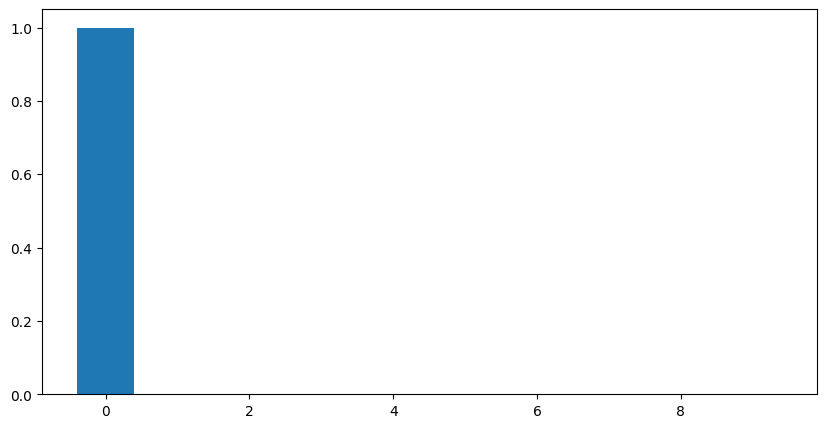

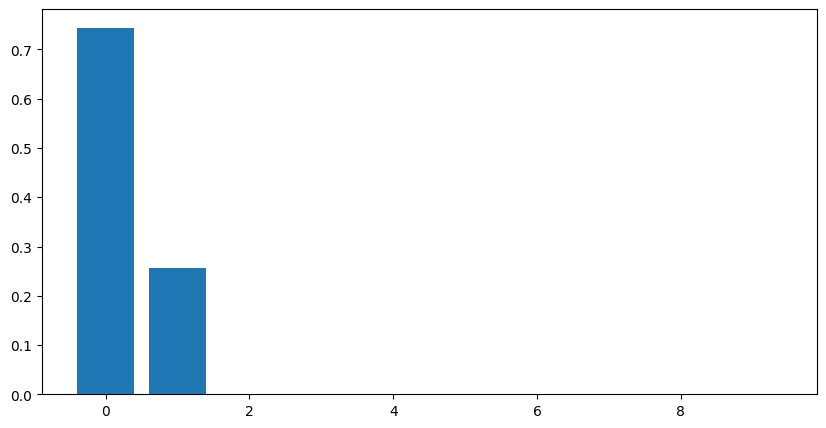

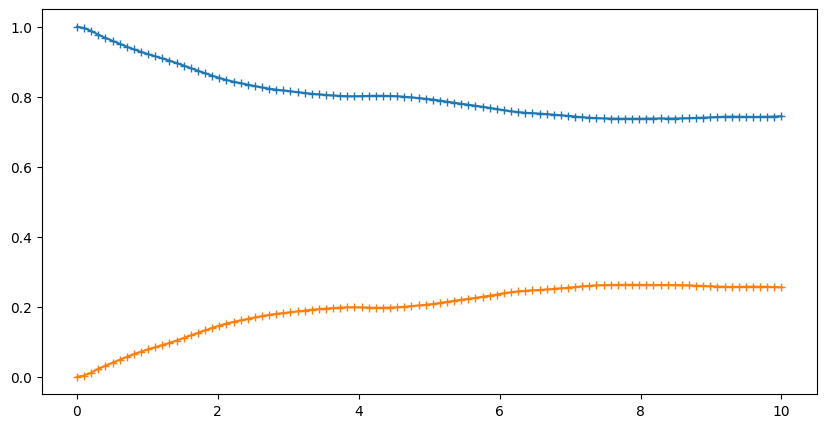

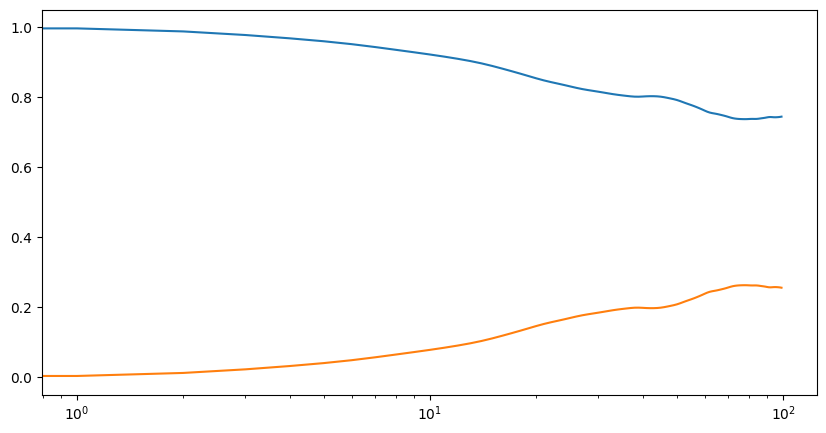

In [16]:
###plotting the top 2 eigenvalues of /rho
#I will probably need to get what is happening with my normalization to do that correctly, which is good

plt.figure(figsize=(10, 5))
s_val = compute_schmidt_states(result, 0, 0, 1)
plt.bar(range(len(s_val)), s_val)

plt.figure(figsize=(10, 5))
s_val = compute_schmidt_states(result, -1, 0, 1) #-1 goes to the max time
plt.bar(range(len(s_val)), s_val)

s_val_0=[]
s_val_1=[]
t_ind = range(len(tlist))
for idx in t_ind:
    s_val_0.append(compute_schmidt_states(result, idx, 0, 1)[0])
for idx in t_ind:
    s_val_1.append(compute_schmidt_states(result, idx, 0, 1)[1])

plt.figure(figsize=(10, 5))
plt.plot(tlist,s_val_0, marker='+')
plt.plot(tlist,s_val_1, marker='+')

plt.figure(figsize=(10, 5))
plt.xscale("log")
plt.plot(s_val_0)
plt.plot(s_val_1)

In [123]:
#generate for thermalization tools
result, tlist, H_q, H_system_2, H_system_1_ext, H_system_2_ext, H_interaction, H_total, ket_0, ket_1, initial_state_system_2 = generate_result(d1,d2,w, E_spacing, 0.1, 10, 1000)
results, tlists, H_qs, H_system_2s, H_system_1_exts, H_system_2_exts, H_interactions, H_totals, ket_0s, ket_1s, initial_state_system_2s = generate_result(d1,d2,w, E_spacing, 0.01, 10, 1000)

In [124]:
#thermalization tools: H_q, H_system_2, H_system_1_ext, H_system_2_ext, H_interaction, H_total
def calculate_expectation_values(tlist, result_states, H_q, H_system_1_ext, H_system_2_ext, H_interaction, H_total):
    E_q = []
    E_s = []
    E_e = []
    E_int = []
    E_tot = []
    
    t_ind = range(len(tlist))
    
    for idx in t_ind:
        E_s.append(qt.expect(H_system_1_ext, result_states[idx]))
    for idx in t_ind:
        E_e.append(qt.expect(H_system_2_ext, result_states[idx]))
    for idx in t_ind:
        E_int.append(qt.expect(H_interaction, result_states[idx]))
    for idx in t_ind:
        E_q.append(qt.expect(H_q, qt.ptrace(result_states[idx], [0])))
    for idx in t_ind:
        E_tot.append(qt.expect(H_total, result_states[idx]))
    
    return E_q, E_s, E_e, E_int, E_tot


In [125]:
E_q, E_s, E_e, E_int, E_tot = calculate_expectation_values(tlists, results.states, H_qs, H_system_1_exts, H_system_2_exts, H_interactions, H_totals)

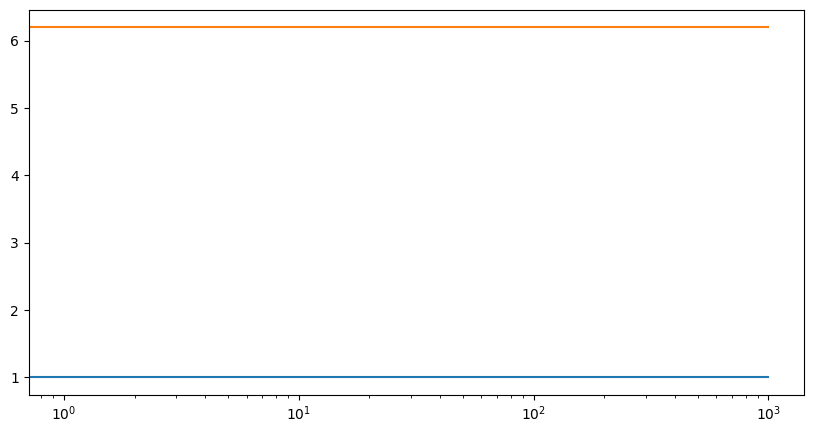

In [126]:

plt.figure(figsize=(10, 5))
plt.xscale("log")
plt.plot(E_s)
plt.plot(E_q)

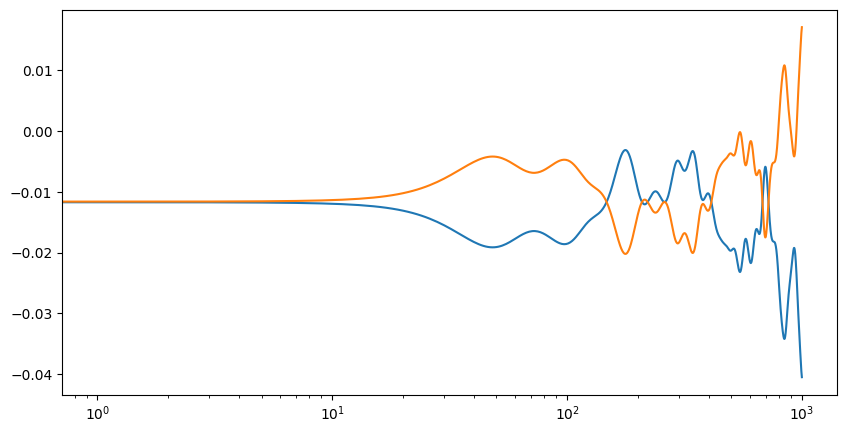

In [127]:
plt.figure(figsize=(10, 5))
plt.xscale("log")
plt.plot(E_int)
plt.plot(E_e)

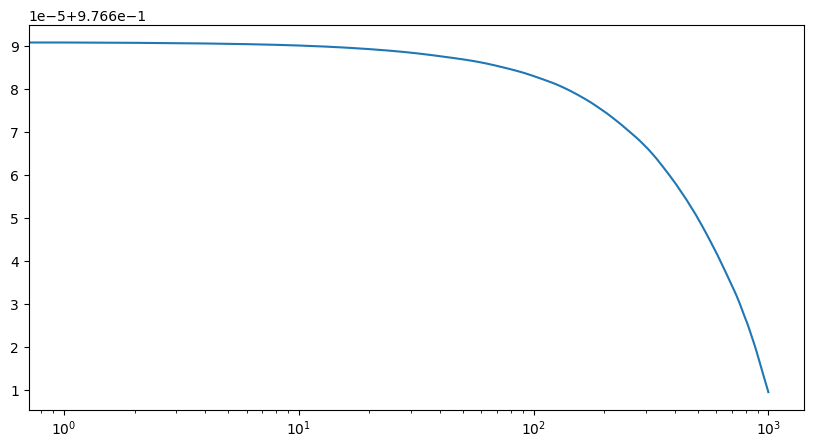

In [128]:
plt.figure(figsize=(10, 5))
plt.xscale("log")
plt.plot(E_tot)

C:\Users\marin\AppData\Local\Temp\ipykernel_4236\3727334809.py:3: RuntimeWarning: divide by zero encountered in log2
  entropy = -np.sum(np.nan_to_num(np.log2(np.linalg.eigvals(density_matrix.full())) * np.linalg.eigvals(density_matrix.full())))
C:\Users\marin\AppData\Local\Temp\ipykernel_4236\3727334809.py:3: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(np.nan_to_num(np.log2(np.linalg.eigvals(density_matrix.full())) * np.linalg.eigvals(density_matrix.full())))


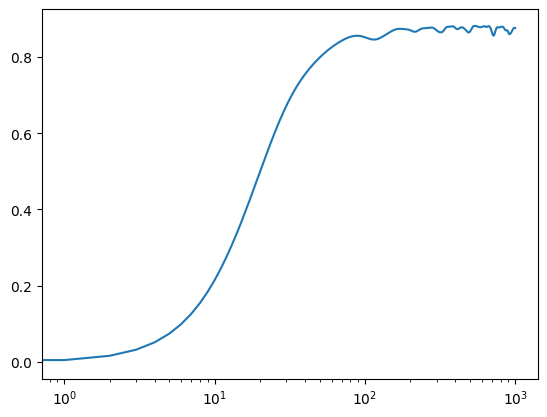

In [129]:
# Define a list to store the Von Neumann entropy at different times and fill it up.
von_neumann_entropy = []
for time_index in range(len(tlist)):
    entropy = compute_VN(result, time_index, subsystem_index=0)
    von_neumann_entropy.append(entropy)
    # ISSUE, does the entropy value make sense?
plt.plot(von_neumann_entropy)
plt.xscale("log")

In [95]:

#Investigating the broadening of the peak of the initial state in the goba energy eigenbasis, which corresponds to starting with a more random state. We want to see what it causes in the projection of schmidt states upon each other.

We consider 1 case already calculated
result2, tlist2, H_q2, H_system_2_2, H_system_1_ext_2, H_system_2_ext_2, H_interaction_2, H_total_2, ket_0_2, ket_1_2, initial_state_system_2_2 = generate_result(d1,d2,w, E_spacing, 0.3, tmax, ind_nb)

Initial state = result2.states[0]
#this corresponds to the sqrt(P) of Andreas
Initial_state_coefficients_in_global_energy_eig = [abs(np.vdot(s0, eigenstate)) for eigenstate in eigenstates_system_total_2]

for idx in t_ind:
    a = compute_schmidt_states(result2, idx, 0, 0)[0] #schmidt 1 on system 1
    b = compute_schmidt_states(result2, idx, 0, 0)[1] #schmidt 2 on system 1
    e = np.tensordot(a, c, 0)
    f = np.tensordot(b, d, 0)
    coef1 = [abs(np.vdot(e, eigenstate)) ** 2 for eigenstate in eigenstates_system_total]
    coef2 = [abs(np.vdot(f, eigenstate)) ** 2 for eigenstate in eigenstates_system_total]

#I am confused. is the schmidt defined globally? No its defined for a subystem
so you can make a vector of the size of the global energy eigenbasis and fill it with the value of the schmidt state in it.
How do I do that? my schmidt is of size 200. I want to project it on vectors of size 2000. 

So a i allowed to say that my 2 worlds are the 2 tensor proiducts of schmidt states of the 2 systems.

Note, the environemnt should start in a schmidt state of itself.

#Current problem N_eff goes to infinity because of the fact that some probabilities are 0.
#idea, when pi = 0, replace 1/pi by pre-determined amount 10^6? NO bad idea, then its more about counting the number of zeros than anything

Big confusion and big difference. the system schmidt state is defined in a 10 dim hilbert space. the world is a 2000 dim state


N = 2000 #dimension of full Hilbert space, automate

def calculate_N_(prob):
    sum_inv_p = sum(1 / p_i for p_i in prob)
    N_eff = 1 / sum_inv_p
    return N_eff


def calculate_delta(N_tot, N_eff):
    delta = N / N_eff
    return delta

#calculate the sequence of delta for the first schmidt state during decoherence
delta_list = []
t_ind = range(len(tlist))

for idx in t_ind:
    #print(idx)
    s0 = result1.states[idx]
    schmidt_coefficients = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates_system_total_1]
    ini_coeff = [abs(np.vdot(initial_state_system_2_0, eigenstates_system_total_1)) ** 2 for eigenstate in eigenstates_system_total_1]
    N_eff = calculate_N_(schmidt_coefficients)
    N_tot = calculate_N_(ini_coeff)
    delta_list.append(calculate_delta(N_tot, N_eff))


SyntaxError: invalid syntax (3413771967.py, line 3)

In [ ]:

#Investigating if the broadening of the peak of the initial state in the goba energy eigenbasis, which corresponds to starting with a more random state causes delta_schmidts of the 2 schmidts to get closer? this is the investigation discussed in the second presentation of Andreas.

#Current problem N_eff goes to infinity because of the fact that some probabilities are 0.
#idea, when pi = 0, replace 1/pi by pre-determined amount 10^6? NO bad idea, then its more about counting the number of zeros than anything
N = 2000 #dimension of full Hilbert space, automate

def calculate_N_(prob):
    sum_inv_p = sum(1 / p_i for p_i in prob)
    N_eff = 1 / sum_inv_p
    return N_eff


def calculate_delta(N_tot, N_eff):
    delta = N / N_eff
    return delta

#calculate the sequence of delta for the first schmidt state during decoherence
delta_list = []
t_ind = range(len(tlist))

for idx in t_ind:
    #print(idx)
    s0 = result1.states[idx]
    schmidt_coefficients = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates_system_total_1]
    ini_coeff = [abs(np.vdot(initial_state_system_2_0, eigenstates_system_total_1)) ** 2 for eigenstate in eigenstates_system_total_1]
    N_eff = calculate_N_(schmidt_coefficients)
    N_tot = calculate_N_(ini_coeff)
    delta_list.append(calculate_delta(N_tot, N_eff))


In [ ]:
print(tlist)
print(delta_list)
#plot over time of delta for the first 3 schmidts. 
plt.figure(figsize=(10, 5))
plt.plot(tlist,delta_list)
plt.show
#plt.plot(tlist,s_val_1, marker='+')

#plt.figure(figsize=(10, 5))
#plt.xscale("log")
#plt.plot(s_val_0)
#plt.plot(s_val_1)

In [ ]:
#“When the system is an apparatus whose intrinsic dynamics can be neglected, pointer states turn out to be eigenstates of the interaction Hamiltonian
#between the apparatus and its environment.”
#Lets check it out




In [ ]:
#plotting the second schmidt state projected over the energy eigenstates
plt.figure(figsize=(10, 5))
for idx in time_indices:
    s1=compute_schmidt_states(result, idx, 1)[1]
    schmidt_coefficients1 = [abs(np.vdot(s1, eigenstate)) ** 2 for eigenstate in eigenstates_system_2]
    plt.plot(eigenenergies_system_2, schmidt_coefficients1, marker='o', label=f'Energy {eigenenergies_system_2}')
plt.show()
